**Description:**

This is the Jupyter notebook is used to test a few classification methods: Logistic regression, Naive Baise, KNN.

**Project Name:** Lending Club

**Team:** Silas Mederer, Jonas Bechthold

**Date:** 2020-10-02 to 2020-10-08

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("data/df_clean.csv")
df.drop("Unnamed: 0", inplace=True, axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41292 entries, 0 to 41291
Data columns (total 14 columns):
loan_amnt               41292 non-null float64
term_is_36              41292 non-null int64
int_rate                41292 non-null float64
grade                   41292 non-null object
sub_grade               41292 non-null object
emp_length              41292 non-null float64
annual_inc              41292 non-null float64
purpose                 41292 non-null object
addr_state              41292 non-null object
dti                     41292 non-null float64
inq_last_6mths          41292 non-null float64
open_acc                41292 non-null float64
pub_rec_bankruptcies    41292 non-null int64
default                 41292 non-null int64
dtypes: float64(7), int64(3), object(4)
memory usage: 4.4+ MB


# Continuous and categorical variables

In [3]:
categorical_var = list(df.select_dtypes('object').columns)
print("categorial var")
print(categorical_var)

categorial var
['grade', 'sub_grade', 'purpose', 'addr_state']


In [4]:
continuous_var = list(df.select_dtypes('int').columns) + list(df.select_dtypes('float').columns)
print("continues var")
print(continuous_var)

continues var
['term_is_36', 'pub_rec_bankruptcies', 'default', 'loan_amnt', 'int_rate', 'emp_length', 'annual_inc', 'dti', 'inq_last_6mths', 'open_acc']


# Correlogram 

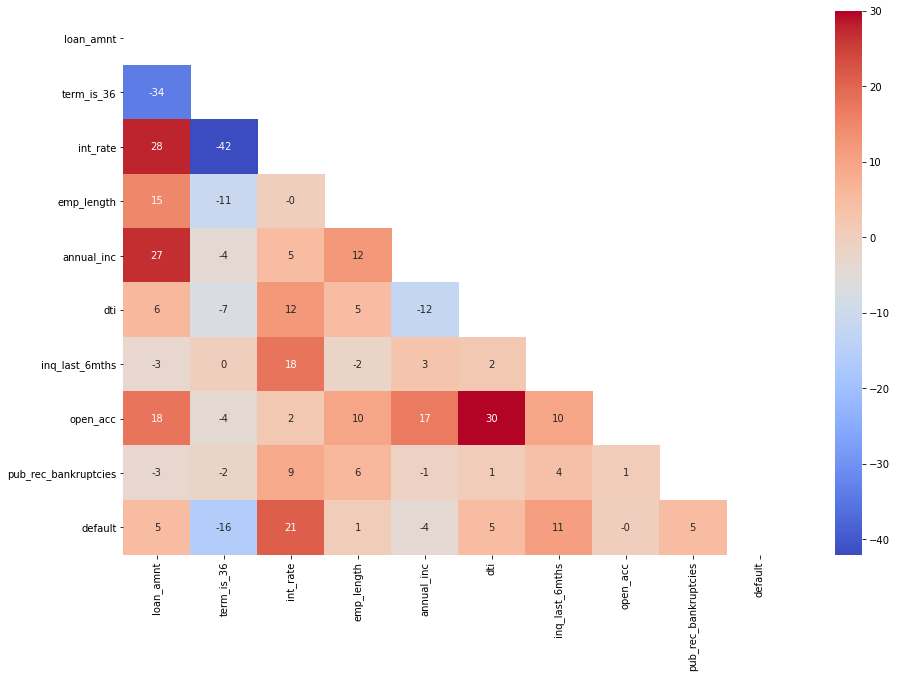

In [5]:
fig, ax = plt.subplots(figsize=(15,10))
mask = np.triu(df.corr())
ax = sns.heatmap(round(df.corr()*100,0)
                 ,annot=True
                 ,mask=mask
                 ,cmap="coolwarm")
plt.savefig('plots/correlogram.png')

# Resample

In [14]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df.default==0]
df_minority = df[df.default==1]

majority_size = df_majority.shape[0]
print(f"Majority Size: {majority_size}")

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=majority_size,    # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.default.value_counts()

Majority Size: 35006


1    35006
0    35006
Name: default, dtype: int64

In [15]:
df = df_upsampled

# Get dummies

In [16]:
X = pd.get_dummies(df.copy(), drop_first=True)
X.drop("default", axis=1, inplace=True)
y = df["default"]

# Split

,train abs,train %,test abs,test %,all abs,all %
1,24504,0.5,10502,0.5,35006,0.5
0,24504,0.5,10502,0.5,35006,0.5


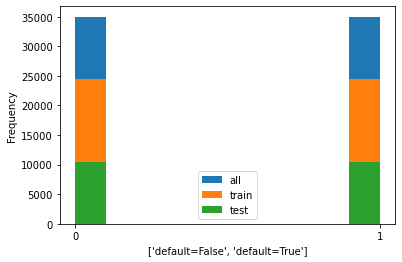

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=25, stratify=y)

# plot
y.plot.hist()
y_train.plot.hist()
y_test.plot.hist()
plt.xlabel(["default=False", "default=True"])
plt.xticks([0, 1])


# dataframe with relative and absolut values
plt.legend(['all','train','test'])
tts_df = pd.DataFrame()
tts_df['train abs'] = round(y_train.value_counts(),2)
tts_df['train %'] = round((y_train.value_counts()/y_train.shape[0]),2)
tts_df['test abs'] = round(y_test.value_counts(),2)
tts_df['test %'] = round((y_test.value_counts()/y_test.shape[0]),2)
tts_df['all abs'] = round(y.value_counts(),2)
tts_df['all %'] = round((y.value_counts()/y.shape[0]),2)
tts_df

# Scaling of the data

In [18]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()

scaling_list = ["dti", "int_rate", "loan_amnt","annual_inc"]
scaling_min_max = ["annual_inc"]

def logarithmize(value):
    #print(value)
    logvalue = np.log(value)
    return logvalue

# scaling train
X_train[scaling_min_max] = X_train[scaling_min_max].apply(lambda x: logarithmize(x))
X_train[scaling_list] = scaler.fit_transform(X_train[scaling_list])

# scaling test with same scaling parameters
X_test[scaling_min_max] = X_test[scaling_min_max].apply(lambda x: logarithmize(x))
X_test[scaling_list] = scaler.transform(X_test[scaling_list])

# Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_train_pred = lr.predict(X_train)

print("Confusion matrix train")
print(confusion_matrix(y_train, y_train_pred))

print("Classification report train")
print(classification_report(y_train, y_train_pred))

print("Confusion matrix test")
print(confusion_matrix(y_test, y_pred))

print("Classification report test")
print(classification_report(y_test, y_pred))

Confusion matrix train
[[16050  8454]
 [ 8368 16136]]
Classification report train
              precision    recall  f1-score   support

           0       0.66      0.65      0.66     24504
           1       0.66      0.66      0.66     24504

    accuracy                           0.66     49008
   macro avg       0.66      0.66      0.66     49008
weighted avg       0.66      0.66      0.66     49008

Confusion matrix test
[[6894 3608]
 [3648 6854]]
Classification report test
              precision    recall  f1-score   support

           0       0.65      0.66      0.66     10502
           1       0.66      0.65      0.65     10502

    accuracy                           0.65     21004
   macro avg       0.65      0.65      0.65     21004
weighted avg       0.65      0.65      0.65     21004



In [21]:
from yellowbrick.classifier import ConfusionMatrix

visualizer = ConfusionMatrix(lr, classes=["Fully Paid", "Default"], support=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

ModuleNotFoundError: No module named 'yellowbrick'

## Optimization

In [25]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
grid_values = {'penalty': ['l1', 'l2'], 'C': [0.001, .009, 0.01, .09, 1, 5, 10, 25]}

# Estimator for use in random search
estimator = LogisticRegression()

# Create the random search model
logreg = RandomizedSearchCV(estimator, grid_values, 
                            n_jobs=-1,
                            scoring='precision', 
                            cv=3,
                            n_iter=20, verbose=1)

# Fit
logreg.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    9.3s finished


RandomizedSearchCV(cv=3, estimator=LogisticRegression(), n_iter=20, n_jobs=-1,
                   param_distributions={'C': [0.001, 0.009, 0.01, 0.09, 1, 5,
                                              10, 25],
                                        'penalty': ['l1', 'l2']},
                   scoring='precision', verbose=1)

In [26]:
y_pred = logreg.predict(X_test)
y_train_pred = logreg.predict(X_train)

print("Confusion matrix train")
print(confusion_matrix(y_train, y_train_pred))

print("Classification report train")
print(classification_report(y_train, y_train_pred))

print("Confusion matrix test")
print(confusion_matrix(y_test, y_pred))

print("Classification report test")
print(classification_report(y_test, y_pred))

Confusion matrix train
[[16050  8454]
 [ 8368 16136]]
Classification report train
              precision    recall  f1-score   support

           0       0.66      0.65      0.66     24504
           1       0.66      0.66      0.66     24504

    accuracy                           0.66     49008
   macro avg       0.66      0.66      0.66     49008
weighted avg       0.66      0.66      0.66     49008

Confusion matrix test
[[6894 3608]
 [3648 6854]]
Classification report test
              precision    recall  f1-score   support

           0       0.65      0.66      0.66     10502
           1       0.66      0.65      0.65     10502

    accuracy                           0.65     21004
   macro avg       0.65      0.65      0.65     21004
weighted avg       0.65      0.65      0.65     21004



# Naive Baise

In [27]:
from sklearn.naive_bayes import GaussianNB

gauss = GaussianNB()
gauss.fit(X_train, y_train)
y_pred = gauss.predict(X_test)
y_test_pred = gauss.predict(X_train)

print("Confusion matrix train")
print(confusion_matrix(y_train, y_train_pred))

print("Classification report train")
print(classification_report(y_train, y_train_pred))

print("Confusion matrix test")
print(confusion_matrix(y_test, y_pred))

print("Classification report test")
print(classification_report(y_test, y_pred))

Confusion matrix train
[[16050  8454]
 [ 8368 16136]]
Classification report train
              precision    recall  f1-score   support

           0       0.66      0.65      0.66     24504
           1       0.66      0.66      0.66     24504

    accuracy                           0.66     49008
   macro avg       0.66      0.66      0.66     49008
weighted avg       0.66      0.66      0.66     49008

Confusion matrix test
[[7430 3072]
 [4912 5590]]
Classification report test
              precision    recall  f1-score   support

           0       0.60      0.71      0.65     10502
           1       0.65      0.53      0.58     10502

    accuracy                           0.62     21004
   macro avg       0.62      0.62      0.62     21004
weighted avg       0.62      0.62      0.62     21004



# KNN

In [28]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train, np.ravel(y_train))

KNeighborsClassifier(metric='euclidean')

In [29]:
y_pred = knn.predict(X_test)
y_test_pred = knn.predict(X_train)

In [30]:
print("Confusion matrix train")
print(confusion_matrix(y_train, y_train_pred))

print("Classification report train")
print(classification_report(y_train, y_train_pred))

print("Confusion matrix test")
print(confusion_matrix(y_test, y_pred))

print("Classification report test")
print(classification_report(y_test, y_pred))

Confusion matrix train
[[16050  8454]
 [ 8368 16136]]
Classification report train
              precision    recall  f1-score   support

           0       0.66      0.65      0.66     24504
           1       0.66      0.66      0.66     24504

    accuracy                           0.66     49008
   macro avg       0.66      0.66      0.66     49008
weighted avg       0.66      0.66      0.66     49008

Confusion matrix test
[[6793 3709]
 [1178 9324]]
Classification report test
              precision    recall  f1-score   support

           0       0.85      0.65      0.74     10502
           1       0.72      0.89      0.79     10502

    accuracy                           0.77     21004
   macro avg       0.78      0.77      0.76     21004
weighted avg       0.78      0.77      0.76     21004



## Optimization

In [31]:
# Hyperparameter grid
grid_values = {'n_neighbors': np.arange(1, 16, 1), 
               'metric': ["euclidean", "manhattan", "minkowski"],
               'weights': ['uniform', 'distance']
              }

# Estimator for use in random search
estimator = KNeighborsClassifier()

# Create the random search model
KNN = RandomizedSearchCV(estimator, grid_values, 
                            n_jobs=-1,
                            scoring='roc_auc', 
                            cv=3,
                            n_iter=20, verbose=1)

# Fit
KNN.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  7.4min finished


RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_iter=20, n_jobs=-1,
                   param_distributions={'metric': ['euclidean', 'manhattan',
                                                   'minkowski'],
                                        'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
                                        'weights': ['uniform', 'distance']},
                   scoring='roc_auc', verbose=1)

In [22]:
print("Confusion matrix train")
print(confusion_matrix(y_train, y_train_pred))

print("Classification report train")
print(classification_report(y_train, y_train_pred))

print("Confusion matrix test")
print(confusion_matrix(y_test, y_pred))

print("Classification report test")
print(classification_report(y_test, y_pred))

Confusion matrix train
[[13592 10912]
 [10819 13685]]
Classification report train
              precision    recall  f1-score   support

           0       0.56      0.55      0.56     24504
           1       0.56      0.56      0.56     24504

    accuracy                           0.56     49008
   macro avg       0.56      0.56      0.56     49008
weighted avg       0.56      0.56      0.56     49008

Confusion matrix test
[[6270 4232]
 [1249 9253]]
Classification report test
              precision    recall  f1-score   support

           0       0.83      0.60      0.70     10502
           1       0.69      0.88      0.77     10502

    accuracy                           0.74     21004
   macro avg       0.76      0.74      0.73     21004
weighted avg       0.76      0.74      0.73     21004

